In [1]:
from Gian_experimental.NSGAIICustom.CustomOperators import NCSamplerFromPRef, NCMutationCounterproductive, \
    NCCrossoverTransition
from Gian_experimental.NSGAIICustom.NSGAIICustom import EvaluatedNCSolution, NCSamplerSimple, NCMutationSimple, \
    NCCrossoverSimple
from scipy.stats import ks_2samp, wasserstein_distance
from Gian_experimental.NSGAIICustom.testing_in_vitro.testing_operators_in_vitro import make_metrics_cached

#dir_250 = r"C:\Users\gac8\PycharmProjects\PSSearch\data\retail_forecasting\250"
# dir_250 = r"/Users/gian/PycharmProjects/PSSearch/data/retail_forecasting/250"

data_path = r"C:\Users\gac8\PycharmProjects\PSSearch\data\retail_forecasting"
import heapq
import itertools
import json
import random
from typing import Iterable, Optional, Iterator

import numpy as np

import utils
from Gian_experimental.NSGAIICustom.testing_in_vitro.SPRef import SPRef, OptimisedSPref
from PolishSystem.OperatorsBasedOnSimilarities.similarities_utils import gian_get_similarities, get_transition_matrix
from PolishSystem.read_data import get_pRef_from_vectors
import os
from PolishSystem.OperatorsBasedOnSimilarities.similarities_utils import get_transition_matrix
from typing import Iterable
import heapq

def in_path(path):
    return os.path.join(data_path, path)



train_pRef = get_pRef_from_vectors(name_of_vectors_file=in_path("train_many_hot_vectors_250_random.csv"),
                                   name_of_fitness_file=in_path("train_fitness_250_random.csv"),
                                   column_in_fitness_file=2)
test_pRef =  get_pRef_from_vectors(name_of_vectors_file=in_path("test_many_hot_vectors_250_random.csv"),
                                   name_of_fitness_file=in_path("test_fitness_250_random.csv"),
                                   column_in_fitness_file=2)

train_SPRef = OptimisedSPref.from_pRef(train_pRef)
test_SPRef = OptimisedSPref.from_pRef(test_pRef)

cluster_info_file_name = in_path(f"cluster_info_250_random.pkl")
similarities = gian_get_similarities(cluster_info_file_name)

n = 250

def keep_ones_with_most_samples(population: Iterable[EvaluatedNCSolution], quantity_required: int):
    return heapq.nsmallest(iterable=population, key=lambda x: x.fitnesses[0], n=quantity_required)

transition_matrix = get_transition_matrix(similarities)
custom_sampling = NCSamplerFromPRef.from_PRef(train_pRef)
custom_mutation = NCMutationCounterproductive(transition_matrix)
custom_crossover = NCCrossoverTransition(transition_matrix)

def atomicity(ps):
    if len(ps) < 2:
        return -1000
    else:
        linkages = [similarities[a, b] for a, b in itertools.combinations(ps, r=2)]
        return np.average(linkages)

traditional_sampling = NCSamplerSimple.with_average_quantity(3, genome_size=n)
traditional_mutation = NCMutationSimple(n)
traditional_crossover = NCCrossoverSimple(swap_probability=1 / n)




In [122]:
from scipy.stats import mannwhitneyu
from Gian_experimental.NSGAIICustom.NSGAIICustom import NCSolution, NSGAIICustom



genome_threshold = 3

def get_metrics(ps: NCSolution) -> tuple[float]:
    # I will use sample size, variance and atomicity

    # for now, simplicity, mean fitness and atomicity
    #simplicity_score = len(ps)
    matching, non_matching = train_SPRef.partition(ps, threshold=genome_threshold)
    len_m, len_nm = len(matching), len(non_matching)
    weighted_variance_score = (np.var(matching) * len_m + np.var(non_matching) * len_nm) / (len_m + len_nm)
    #mean_fitness = np.average(matching) if len(matching) > 0 else -1000
    median_diff = np.median(matching) - np.median(non_matching)
    distance = wasserstein_distance(matching, non_matching) if min(len(matching), len(non_matching)) > 2 else 0
    #is_beneficial = np.average(matching) > np.average(non_matching)
    # if is_beneficial:
    #     distance *= -1
    #print(distance)
    atomicity_score = atomicity(ps)
    
    if len(matching) < 1000: # a constraint
        return 1000, 1000, 1000, 1000, 1000

    return (len(ps), -len(matching), -distance, -median_diff, -atomicity_score)

algorithm = NSGAIICustom(sampling=traditional_sampling,
                         mutation=traditional_mutation,
                         crossover=traditional_crossover,
                         probability_of_crossover=0.5,
                         eval_budget=5000,
                         pop_size=100,
                         tournament_size=3,
                         mo_fitness_function=make_metrics_cached(get_metrics),
                         unique=True,
                         verbose=True,
                         culler=keep_ones_with_most_samples
                         )

In [123]:
results  = algorithm.run()

NSGAIICustom -> Beginning of NC process
NSGAIICustom -> Used evals: 216
NSGAIICustom -> Used evals: 325
NSGAIICustom -> Used evals: 432
NSGAIICustom -> Used evals: 543
NSGAIICustom -> Used evals: 655
NSGAIICustom -> Used evals: 761
NSGAIICustom -> Used evals: 870
NSGAIICustom -> Used evals: 981
NSGAIICustom -> Used evals: 1086
NSGAIICustom -> Used evals: 1200
NSGAIICustom -> Used evals: 1306
NSGAIICustom -> Used evals: 1412
NSGAIICustom -> Used evals: 1519
NSGAIICustom -> Used evals: 1623
NSGAIICustom -> Used evals: 1733
NSGAIICustom -> Used evals: 1843
NSGAIICustom -> Used evals: 1948
NSGAIICustom -> Used evals: 2053
NSGAIICustom -> Used evals: 2167
NSGAIICustom -> Used evals: 2274
NSGAIICustom -> Used evals: 2390
NSGAIICustom -> Used evals: 2501
NSGAIICustom -> Used evals: 2606
NSGAIICustom -> Used evals: 2711
NSGAIICustom -> Used evals: 2822
NSGAIICustom -> Used evals: 2928
NSGAIICustom -> Used evals: 3036
NSGAIICustom -> Used evals: 3143
NSGAIICustom -> Used evals: 3246
NSGAIICusto

There are 91 results
(6, -1906, -3.478346951473615, -3.2083730697631836, -1.5290564) 6
(7, -3042, -2.978790156328592, -2.7140378952026367, -0.7908832) 7
(6, -2410, -3.181574933118705, -2.911224365234375, -0.72131085) 6
(6, -1180, -3.791428470268433, -3.641249656677246, -0.33571085) 6
(6, -2904, -2.969355800864272, -2.7432546615600586, 0.1971863) 6
(6, -3600, -2.864575702914809, -2.618924617767334, -0.5427624) 6
(7, -2946, -2.9426221735457547, -2.6839990615844727, -1.1047028) 7
(6, -1709, -3.5043335447308896, -3.376033067703247, -0.30520254) 6
(6, -2060, -3.3197579024594877, -3.053060531616211, -0.6321569) 6
(6, -2376, -3.0202868838424397, -2.7494263648986816, -1.4103593) 6
(7, -2969, -2.7204870532877115, -2.463844060897827, -1.5381272) 7
(6, -2860, -2.970909188599531, -2.7167587280273438, -0.8530442) 6
(12, -5514, -2.0821326067667103, -1.8692893981933594, -0.4731393) 12
(6, -1601, -3.4082676465159802, -3.1651322841644287, -1.8910792) 6
(6, -2316, -3.159075463126583, -2.889906883239746,

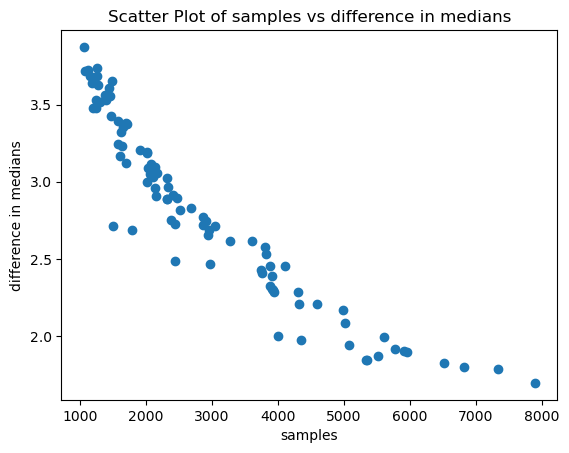

In [124]:
print(f"There are {len(results)} results")

for result in results:
    print(result.fitnesses, len(result.solution))
    
    
    
col_a = 1
col_b = 3
vals_a = [-ps.fitnesses[col_a] for ps in results if len(ps.solution) > 1]
vals_b = [-ps.fitnesses[col_b] for ps in results if len(ps.solution) > 1]

utils.simple_scatterplot(x_label="samples", y_label="difference in medians", xs=vals_a, ys=vals_b)

In [125]:


from matplotlib import pyplot as plt
from Gian_experimental.plotting_utils import display_side_by_side

def compare_histograms(
    data1,
    data2,
    bins=30,
    log_x=False,
    log_y=False,
    labels=("Data 1", "Data 2"),
    title="Histogram Comparison",
    figsize=(6, 4),
    ax=None,
    y_axis_frequency="absolute",  # "absolute" or "relative"
):
    """
    Creates a histogram comparison plot of two datasets on a given Axes or a new figure.

    Parameters:
        ...
        y_axis_frequency (str): "absolute" for counts, "relative" for percentages (0–100%).

    Returns:
        matplotlib.figure.Figure or None
    """
    data1 = np.array(data1)
    data2 = np.array(data2)

    if log_x:
        data1 = data1[data1 > 0]
        data2 = data2[data2 > 0]
        combined = np.concatenate([data1, data2])
        min_val = combined.min()
        max_val = combined.max()
        bins = np.logspace(np.log10(min_val), np.log10(max_val), bins)

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = None

    density = y_axis_frequency == "relative"

    ax.hist(data1, bins=bins, alpha=0.5, label=labels[0], edgecolor='black', density=density)
    ax.hist(data2, bins=bins, alpha=0.5, label=labels[1], edgecolor='black', density=density)

    if log_x:
        ax.set_xscale('log')
    if log_y:
        ax.set_yscale('log')

    ax.set_xlabel("Value")
    ax.set_ylabel("Percentage" if density else "Frequency")

    if density:
        # Convert y-axis to percentage
        ticks = ax.get_yticks()
        ax.set_yticklabels([f"{tick*100:.0f}%" for tick in ticks])

    ax.set_title(title)
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    return fig

def display_side_by_side(histogram_args_list, figsize_per_plot=(5, 5)):
    """
    Displays multiple histograms side-by-side using `compare_histograms`.

    Parameters:
        histogram_args_list (list[dict]): Each dict contains args for `compare_histograms`.
        figsize_per_plot (tuple): Size per individual plot; used to scale total figure.
    """
    num = len(histogram_args_list)
    total_figsize = (figsize_per_plot[0] * num, figsize_per_plot[1])
    fig, axs = plt.subplots(1, num, figsize=total_figsize)

    if num == 1:
        axs = [axs]  # Ensure it's iterable

    for args, ax in zip(histogram_args_list, axs):
        compare_histograms(ax=ax, **args)

    plt.tight_layout()
    plt.show()


def get_textual_description_of_distribution(values):
    return (f"n = {len(values)},\n"
              f"average = {np.average(values):.2f}, median = {np.median(values):.2f}\n"
              f"min = {np.min(values):.2f}, max = {np.max(values):.2f},\n")

def make_ps_into_explanation(ps, genome_threshold, test_SPref: SPRef):
    print(f"If you match this list of {len(ps)}, with threshold {genome_threshold}:")
    print(ps)
    

    match_fitnesses, match_non_fitnesses = test_SPref.partition(ps, genome_threshold)
    
    if len(match_fitnesses) < 100 or len(match_non_fitnesses) < 100:
        print(f"There are not enough matches!!!  {len(match_fitnesses)}, {len(match_non_fitnesses)}")
        return
    all_fitnesses = test_SPref.fitnesses
    distance = wasserstein_distance(match_fitnesses, match_non_fitnesses)
    
    print(f"The Wasserstein distance is {distance}")
    print("Distribution of match fitness")
    print(utils.indent(get_textual_description_of_distribution(match_fitnesses)))
    print("Distribution of non match fitness")
    print(utils.indent(get_textual_description_of_distribution(match_non_fitnesses)))
    
    display_side_by_side([
            {
                "data1": match_fitnesses,
                "data2": match_non_fitnesses,
                "title": f"Fitnesses of matches vs non-matches",
                "labels": ("Matches", "Non matches"),
                "y_axis_frequency": "relative"
            },
            {
                "data1": match_fitnesses,
                "data2": match_non_fitnesses,
                "title": f"Absolute view",
                "labels": ("Matches", "Non Matches"),
                "y_axis_frequency": "absolute"
            }
        ])

91 are satisfactory out of 91
The metrics were (6, -1304, -3.6893180701056334, -3.519376754760742, -2.215738)
If you match this list of 6, with threshold 3:
{65, 215, 152, 154, 157, 190}
The Wasserstein distance is 3.8616122222359066
Distribution of match fitness
	n = 574,
	average = 11.38, median = 11.16
	min = 2.72, max = 38.68,
	
Distribution of non match fitness
	n = 15264,
	average = 7.52, median = 7.36
	min = 0.07, max = 33.66,
	


C:\Users\gac8\AppData\Local\Temp\ipykernel_20536\1873478931.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{tick*100:.0f}%" for tick in ticks])


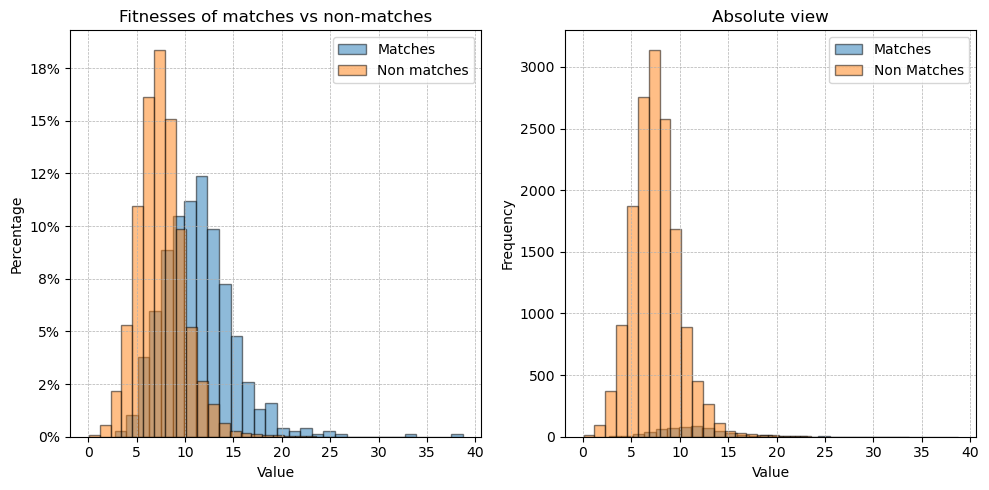

In [140]:
threshold_proportion_train = 0.1  # at least 10 %
threshold_quantity_train = round(len(train_SPRef.fitnesses) * threshold_proportion_train) 
def has_enough_matches_in_train(result_of_NSGAII: EvaluatedNCSolution):
    #print(f"Checking {result_of_NSGAII}")
    match_fitnesses, match_non_fitnesses = train_SPRef.partition(result_of_NSGAII.solution, genome_threshold)
    proportion = len(match_fitnesses) / len(train_SPRef.fitnesses)
    #print(proportion)
    return True

satisfactory_pss = list(filter(has_enough_matches_in_train, results))

print(f"{len(satisfactory_pss)} are satisfactory out of {len(results)}")
        

for result in sorted(satisfactory_pss, key=lambda x: x.fitnesses[-1], reverse=False)[:1]:
    print(f"The metrics were {result.fitnesses}")
    make_ps_into_explanation(result.solution, genome_threshold=genome_threshold, test_SPref=test_SPRef)

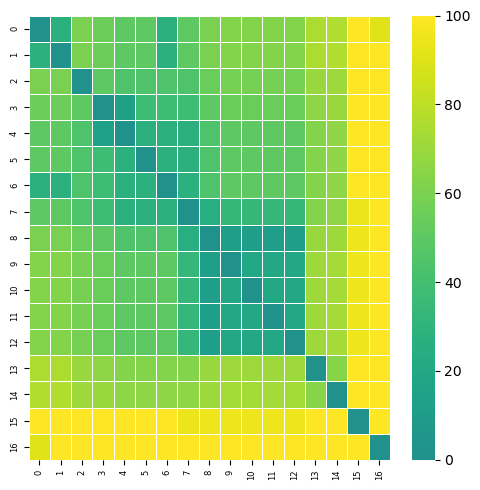

In [114]:


from initial_testing.understand_files.rearrange_linkage_table import clean_table
from collections import defaultdict



def distance_function(a: set, b: set):
    return 100 * len(set.union(a, b) - a.intersection(b)) / len(set.union(a, b))
    

to_show = satisfactory_pss
quantity = len(to_show)
distance_matrix = np.zeros(shape=(quantity, quantity), dtype=int)
for i, j in itertools.combinations(range(quantity), r=2):
    distance_matrix[i, j] = distance_function(to_show[i].solution, to_show[j].solution)


distance_matrix += distance_matrix.T

utils.show_matrix_with_colours(clean_table(distance_matrix), fig_size=(5, 5))


# the table makes me think that #2 is different from everything else, so let's consider 0 and 2






    

C:\Users\gac8\AppData\Local\Temp\ipykernel_20536\1873478931.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{tick*100:.0f}%" for tick in ticks])


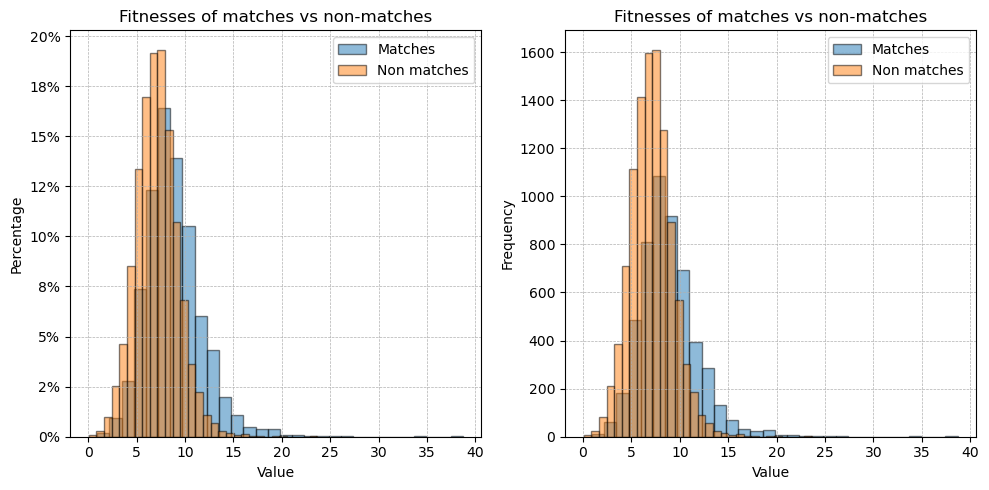

In [115]:
matches_by_any, non_matches_by_any = ([], [])


SPRef_to_get_from = test_SPRef
pss_to_consider =satisfactory_pss
for session, fitness in zip(SPRef_to_get_from.sessions, SPRef_to_get_from.fitnesses):
    def matches_pattern(run_result):
        return len(run_result.solution.intersection(session)) >=genome_threshold
    if any(map(matches_pattern, pss_to_consider)):
        matches_by_any.append(fitness)
    else:
        non_matches_by_any.append(fitness)


display_side_by_side([
    {
        "data1": matches_by_any,
        "data2": non_matches_by_any,
        "title": f"Fitnesses of matches vs non-matches",
        "labels": ("Matches", "Non matches"),
        "y_axis_frequency": "relative"
    },
    {
        "data1": matches_by_any,
        "data2": non_matches_by_any,
        "title": f"Fitnesses of matches vs non-matches",
        "labels": ("Matches", "Non matches"),
        "y_axis_frequency": "absolute"
    },
])
            
    